<a href="https://colab.research.google.com/github/simjeongho/XceptionV2/blob/main/XceptionImproved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as tr
import numpy as np 
from torch.utils.data import Dataset, DataLoader
from torch import optim

In [3]:
# transf = tr.Compose([tr.Resize(16), tr.ToTensor()]) # 16x16으로 이미지 변환

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transf)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transf)

# #DataLoader는 데이터를 미니 배치 형태로 만들어준다. 
# #따라서 배치 사이즈 및 셔플 여부 등을 선택할 수 있다. 
# trainLoader = DataLoader(trainset, batch_size=32, shuffle=True)
# testLoader = DataLoader(testset, batch_size=32, shuffle=True);
# len(trainLoader)


모델의 성능을 학습시켜 보는 테스트 이미지 셋으로 CIFAR10


좀 더 알아 보기 쉬운 코드 작성

In [4]:
transform = tr.Compose(
    [tr.ToTensor(),
     tr.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testLoader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
print(trainset[0][0].size())

torch.Size([3, 32, 32])


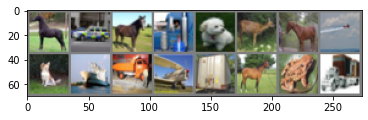

horse car   horse truck dog   deer  horse plane dog   ship  truck plane truck horse frog  truck


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainLoader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

데이터 확인하기 

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} isavailable')
# GPU 사용 할 것임

cuda:0 isavailable


In [8]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride, padding):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        
        return x
    

class SeparableConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(SeparableConv, self).__init__()
        
        # 3x3 필터를 통한 공간 연산, 인풋 채널과 아웃풋 채널을 같게 해서 채널은 가만히 둔다. groups 변수 중요.
        self.depthwise = nn.Conv2d(in_ch, in_ch, kernel_size=3, stride=1, padding=1, groups=in_ch, bias=False)
        
        # 1x1 필터를 통한 채널 연산, 필터 크기를 1x1로 해서 공간(feature map 크기)은 가만히 둔다
        self.pointwise = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn = nn.BatchNorm2d(out_ch)
        
    def forward(self, x):
        
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        
        return x

pointwise와 depth wise의 순서는 별로 중요하지 않다. 어차피 모델이 진행되며 섞이기 때문이다. ababab -> bababa비슷함


In [9]:
# Entry Flow    

class Entry(nn.Module):
    def __init__(self):
        super(Entry, self).__init__()
        
        self.relu = nn.ReLU()
        
        self.conv_32 = ConvBlock(3, 32, kernel_size=3, stride=2, padding=1)
        self.conv_64 = ConvBlock(32, 64, kernel_size=3, stride=1, padding=1)
        
        self.conv1x1_64 = ConvBlock(64, 128, kernel_size=1, stride=2, padding=0)
        self.conv1x1_128 = ConvBlock(128, 256, kernel_size=1, stride=2, padding=0)
        self.conv1x1_256 = ConvBlock(256, 728, kernel_size=1, stride=2, padding=0)
        
        self.sepconv1 = SeparableConv(64, 128)
        self.sepconv2 = SeparableConv(128, 128)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.sepconv3 = SeparableConv(128, 256)
        self.sepconv4 = SeparableConv(256, 256)
        
        self.sepconv5 = SeparableConv(256, 728)
        self.sepconv6 = SeparableConv(728, 728)
        
    def forward(self, x):
        
        x = self.conv_32(x)
        x = self.conv_64(x)
        
        pre_x1 = x
        pre_x1 = self.conv1x1_64(x)
        
        x = self.sepconv1(x)
        
        x = self.relu(x)        
        x = self.sepconv2(x)
        
        x = self.maxpool(x)
        
        pre_x2 = x
        pre_x2 = self.conv1x1_128(x)
        
        x = self.relu(x+pre_x1)
        x = self.sepconv3(x)
        
        x = self.relu(x)
        x = self.sepconv4(x)
        
        x = self.maxpool(x)
        
        pre_x3 = x
        pre_x3 = self.conv1x1_256(x)
        
        x = self.relu(x+pre_x2)
        x = self.sepconv5(x)
        
        x = self.relu(x)
        x = self.sepconv6(x)
        
        x = self.maxpool(x)
        
        return x+pre_x3

EntryFlow에 해당한다. 


In [10]:
if __name__ == '__main__':

    from torchsummary import summary
    model = Entry().to(device)
    summary(model, (3,299,299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 150, 150]             864
       BatchNorm2d-2         [-1, 32, 150, 150]              64
              ReLU-3         [-1, 32, 150, 150]               0
         ConvBlock-4         [-1, 32, 150, 150]               0
            Conv2d-5         [-1, 64, 150, 150]          18,432
       BatchNorm2d-6         [-1, 64, 150, 150]             128
              ReLU-7         [-1, 64, 150, 150]               0
         ConvBlock-8         [-1, 64, 150, 150]               0
            Conv2d-9          [-1, 128, 75, 75]           8,192
      BatchNorm2d-10          [-1, 128, 75, 75]             256
             ReLU-11          [-1, 128, 75, 75]               0
        ConvBlock-12          [-1, 128, 75, 75]               0
           Conv2d-13         [-1, 64, 150, 150]             576
           Conv2d-14        [-1, 128, 1

torch의 summary를 도입하면 파라미터 수등 모델의 정보를 알 수 있다. 


In [11]:
# Middle Flow

class Middle(nn.Module):
    def __init__(self):
        super(Middle, self).__init__()
        
        self.relu = nn.ReLU()
        self.sepconv = SeparableConv(728, 728)
        
    def forward(self, x):
        
        pre_x = x
        
        for _ in range(3):
            x = self.relu(x)
            x = self.sepconv(x)
        
        return x+pre_x

In [12]:

if __name__ == '__main__':

    from torchsummary import summary
    model = Middle().to(device)
    summary(model, (728,19,19))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              ReLU-1          [-1, 728, 19, 19]               0
            Conv2d-2          [-1, 728, 19, 19]           6,552
            Conv2d-3          [-1, 728, 19, 19]         529,984
       BatchNorm2d-4          [-1, 728, 19, 19]           1,456
     SeparableConv-5          [-1, 728, 19, 19]               0
              ReLU-6          [-1, 728, 19, 19]               0
            Conv2d-7          [-1, 728, 19, 19]           6,552
            Conv2d-8          [-1, 728, 19, 19]         529,984
       BatchNorm2d-9          [-1, 728, 19, 19]           1,456
    SeparableConv-10          [-1, 728, 19, 19]               0
             ReLU-11          [-1, 728, 19, 19]               0
           Conv2d-12          [-1, 728, 19, 19]           6,552
           Conv2d-13          [-1, 728, 19, 19]         529,984
      BatchNorm2d-14          [-1, 728,

Middle Flow에 해당하는 코드이다. 

In [13]:
# Exit Flow

class Exit(nn.Module):
    def __init__(self):
        super(Exit, self).__init__()
        
        self.relu = nn.ReLU()
        self.conv1x1_728 = ConvBlock(728, 1024, kernel_size=1, stride=2, padding=0)
        
        self.sepconv1 = SeparableConv(728, 728)
        self.sepconv2 = SeparableConv(728, 1024)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.sepconv3 = SeparableConv(1024, 1536)
        self.sepconv4 = SeparableConv(1536, 2048)
        
        self.dropout = nn.Dropout(0.5)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(2048, 1000)
        
    def forward(self, x):
        
        pre_x = x
        pre_x = self.conv1x1_728(x)
        
        x = self.relu(x)
        x = self.sepconv1(x)
        
        x = self.relu(x)
        x = self.sepconv2(x)
        
        x = self.maxpool(x)
        
        x = self.sepconv3(pre_x+x)
        x = self.relu(x)
        
        x = self.sepconv4(x)
        x = self.relu(x)
        
        x = self.dropout(x)
        x = self.avgpool(x)
        
        x = x.view(x.size(0),-1)
        x = self.linear(x)
        
        return x

In [14]:
if __name__ == '__main__':

    from torchsummary import summary
    model = Exit().to(device)
    summary(model, (728,19,19))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 1024, 10, 10]         745,472
       BatchNorm2d-2         [-1, 1024, 10, 10]           2,048
              ReLU-3         [-1, 1024, 10, 10]               0
         ConvBlock-4         [-1, 1024, 10, 10]               0
              ReLU-5          [-1, 728, 19, 19]               0
            Conv2d-6          [-1, 728, 19, 19]           6,552
            Conv2d-7          [-1, 728, 19, 19]         529,984
       BatchNorm2d-8          [-1, 728, 19, 19]           1,456
     SeparableConv-9          [-1, 728, 19, 19]               0
             ReLU-10          [-1, 728, 19, 19]               0
           Conv2d-11          [-1, 728, 19, 19]           6,552
           Conv2d-12         [-1, 1024, 19, 19]         745,472
      BatchNorm2d-13         [-1, 1024, 19, 19]           2,048
    SeparableConv-14         [-1, 1024,

exit Flow에 해당하는 코드이다. 

In [15]:
class Xception(nn.Module):    
    def __init__(self):
        super(Xception, self).__init__()
        
        self.entry = Entry()
        self.middle = Middle()
        self.exit = Exit()
        
    def forward(self, x):
        
        x = self.entry(x)        
        for _ in range(8):
            x = self.middle(x)  # Middle Flow는 8번 수행           
        x = self.exit(x)
        
        return x

In [16]:
if __name__ == '__main__':

    from torchsummary import summary
    xception = Xception().to(device)
    summary(xception, (3,299,299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 150, 150]             864
       BatchNorm2d-2         [-1, 32, 150, 150]              64
              ReLU-3         [-1, 32, 150, 150]               0
         ConvBlock-4         [-1, 32, 150, 150]               0
            Conv2d-5         [-1, 64, 150, 150]          18,432
       BatchNorm2d-6         [-1, 64, 150, 150]             128
              ReLU-7         [-1, 64, 150, 150]               0
         ConvBlock-8         [-1, 64, 150, 150]               0
            Conv2d-9          [-1, 128, 75, 75]           8,192
      BatchNorm2d-10          [-1, 128, 75, 75]             256
             ReLU-11          [-1, 128, 75, 75]               0
        ConvBlock-12          [-1, 128, 75, 75]               0
           Conv2d-13         [-1, 64, 150, 150]             576
           Conv2d-14        [-1, 128, 1

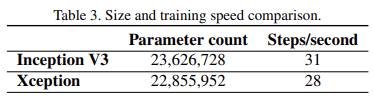
논문의 파라미터 수와 일치한다. 


In [17]:
print(xception)

Xception(
  (entry): Entry(
    (relu): ReLU()
    (conv_32): ConvBlock(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv_64): ConvBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv1x1_64): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv1x1_128): ConvBlock(
      (conv): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv1x1_256): ConvBlo

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(xception.parameters(), lr=0.045, momentum=0.9)

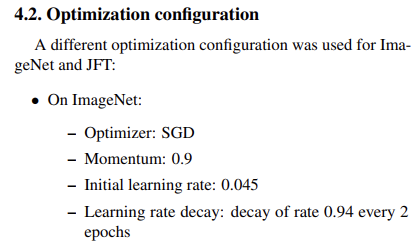
논문에 존재하던 파라미터로 사용

In [19]:
print(trainLoader)

In [20]:

loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트 
n = len(trainLoader) # 배치 개수

for epoch in range(10):  # 10번 학습을 진행한다.

    running_loss = 0.0
    for i, data in enumerate(trainLoader, 0):

        inputs, labels = data[0].to(device), data[1].to(device) # 배치 데이터 
        
        optimizer.zero_grad()

        outputs = xception(inputs) # 예측값 산출 
        loss = criterion(outputs, labels) # 손실함수 계산
        loss.backward() # 손실함수 기준으로 역전파 선언
        optimizer.step() # 가중치 최적화

        # print statistics
        running_loss += loss.item()

    loss_.append(running_loss / n)    
    print('[%d] loss: %.3f' %(epoch + 1, running_loss / len(trainLoader)))

print('Finished Training')


[1] loss: 3.013
[2] loss: 2.298
[3] loss: 2.251
[4] loss: 2.212
[5] loss: 2.172
[6] loss: 2.135
[7] loss: 2.112
[8] loss: 2.055
[9] loss: 2.025
[10] loss: 1.996
Finished Training


In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()